In [1]:
# For extracting the eigenvalue from the ground state estimate, we will use 
# Quantum Phase Estimation, sampled over a data set with different time steps.

In [1]:
import sys

sys.path.append("../../src/groundstate_prep")
from ground_state_prep import prepare_ground_state
from utils_gsp import approx_polynomial, get_phis, U

sys.path.append("../../src/lindbladian")
from lindbladian import ideal_lindbladian, circuit_implementation_lindbladian
from utils_lind import crandn

sys.path.append("../../src/rqcopt")
from optimize import ising1d_dynamics_opt

In [2]:
# Hamiltonian.

import numpy as np
from numpy import linalg as LA
import qib
import matplotlib.pyplot as plt

# Parameters for the Ising Hamiltonian
# L has to be even! Due to K only being able to control even Ls!
L, J, h, g = (6, 1, 0, 1)


# construct Hamiltonian
latt = qib.lattice.IntegerLattice((L,), pbc=True)
field = qib.field.Field(qib.field.ParticleType.QUBIT, latt)
hamil = qib.IsingHamiltonian(field, J, h, g).as_matrix().toarray()

eigenvalues, eigenvectors = LA.eig(hamil)
idx = eigenvalues.argsort()
eigenvalues_sort = eigenvalues[idx]
eigenvectors_sort = eigenvectors[:,idx]
ground_state = eigenvectors_sort[:, 0]
print("Ground State Energy", eigenvalues_sort[0].real)

Ground State Energy -7.727406610312557


In [3]:
# Linear transformation of the hamiltonian to fit the eigenvalues in the [-1, 1] interval.

dist = 0.001

# Have to be guessed, depending on the used Hamiltonian
# If we have a good initial overlap, we can decrease this 
# max_spectrum_length and get a larger spectral gap after transformation.
max_spectrum_length = 16
ground_energy_lower_bound = -12
c1 = (np.pi-2*dist) / (max_spectrum_length)
c2 = dist - c1 * ground_energy_lower_bound

eigenvalues_tr = eigenvalues_sort * c1 + c2
a_values = np.array([np.cos(eig/2) for eig in eigenvalues_tr])

print("a_max", a_values[0])
print("a_premax", a_values[1])
print("c1: ", c1)
print("c2: ", c2)
print("t: ", 0.5*c1)

a_max (0.9132137382459501-0j)
a_premax (0.9023835642429388-0j)
c1:  0.19622454084936208
c2:  2.3556944901923447
t:  0.09811227042468104


In [4]:
mu, d, c, phis_max_iter, = (0.92, 30, 0.95, 10)

end_state_qetu, E = prepare_ground_state(
                        np.array([1 if i == 0 else 0 for i in range(2**(L+1))]), mu, d, c, phis_max_iter,
                        np.kron(np.array([1, 0]), ground_state), L, J, g, eigenvalues_sort[0],
                        hamil=hamil, max_reps=5, tau=c1, shift=c2, a_max=a_values[0]
)


Layer 0
Prob 0: 0.000601119606010127
Prob 1: 0.9993988803939866

Layer 1
Prob 0: 0.01096811364031365
Prob 1: 0.9890318863596836

Layer 2
Prob 0: 0.10899893272278838
Prob 1: 0.8910010672772267

Layer 3
Prob 0: 0.11574457330495695
Prob 1: 0.8842554266950593

Layer 4
Prob 0: 0.11581435497796187
Prob 1: 0.8841856450220541

F(a_max) = (0.1158362843049955+0j)

 ---------- 
 SUCCESS! 

Fidelity of the initial state to the ground state: 0.0004623159943540674
Fidelity of the prepared state to the ground state: 0.9999995591131223


In [5]:
t = 1
exact_phase = np.exp(-1j*t*eigenvalues_sort[0])

In [6]:
import scipy

def controlled_trotterized_time_evolution(qc, coeffs, hloc, dt, L):
    Vlist = [scipy.linalg.expm(-1j*c*dt*hloc) for c in coeffs]
    Vlist_gates = []
    for V in Vlist:
        qc2 = qiskit.QuantumCircuit(2)
        qc2.unitary(V, [0, 1], label='str')
        Vlist_gates.append(qc2)
    perms = [None if i % 2 == 0 else np.roll(range(L), -1) for i in range(len(coeffs))]
    for layer, qc_gate in enumerate(Vlist_gates):
        for j in range(L//2):
            if perms[layer] is not None:
                qc.append(qc_gate.to_gate().control(), [L, L-(perms[layer][2*j]+1), L-(perms[layer][2*j+1]+1)])
            else:
                qc.append(qc_gate.to_gate().control(), [L, L-(2*j+1), L-(2*j+2)])

In [32]:
# QPE circuit, qiskit implementation.

import qiskit
import h5py
import rqcopt as oc
from utils_gsp import construct_ising_local_term

qpe_real = qiskit.QuantumCircuit(L+1, 1)
qpe_real.initialize(end_state_qetu)
qpe_real.h(L)

qpe_bm_real = qpe_real.copy()
qpe_strang3_real = qpe_real.copy()

#---------------------------------Blanes-Moan PRK-4, 13 Layers--------------------------------------------------
dt = t/1
hloc = construct_ising_local_term(J, g)
coeffs = oc.SplittingMethod.blanes_moan().coeffs
controlled_trotterized_time_evolution(qpe_bm_real, coeffs, hloc, dt, L)

#---------------------------------Strang Splitting, 5 Layers--------------------------------------------------
strang = oc.SplittingMethod.suzuki(2, 1)
_, coeffs = oc.merge_layers(2*strang.indices, 2*strang.coeffs)
coeffs = [0.5*c for c in coeffs]
controlled_trotterized_time_evolution(qpe_strang3_real, coeffs, hloc, dt, L)

#---------------------------------RQCOpt Encoding, 5 Layers---------------------------------------------------

V_list = []
path = f"../../src/rqcopt/results/ising1d_L{L}_t{t}_dynamics_opt_layers5.hdf5"
try:
    with h5py.File(path, "r") as f:
        assert f.attrs["L"] == L
        assert f.attrs["J"] == J
        assert f.attrs["g"] == g
        V_list = list(f["Vlist"])
except FileNotFoundError:
    strang = oc.SplittingMethod.suzuki(2, 1)
    _, coeffs_start_n5 = oc.merge_layers(2*strang.indices, 2*strang.coeffs)
    # divide by 2 since we are taking two steps
    coeffs_start_n5 = [0.5*c for c in coeffs_start_n5]
    print("coeffs_start_n5:", coeffs_start_n5)
    V_list = ising1d_dynamics_opt(5, 1, False, coeffs_start_n5, path, niter=16)
    
perms = [None if i % 2 == 0 else np.roll(range(L), -1) for i in range(len(V_list))]
qcs_rqc = []
for V in V_list:
    qc_rqc = qiskit.QuantumCircuit(2)
    qc_rqc.unitary(V, [0, 1])
    qcs_rqc.append(qc_rqc)
for layer, qc_gate in enumerate(qcs_rqc):
    cgate = qc_gate.to_gate().control()
    for j in range(L//2):
        if perms[layer] is not None:
            qpe_real.append(cgate, [L, L-(perms[layer][2*j]+1), L-(perms[layer][2*j+1]+1)])
        else:
            qpe_real.append(cgate, [L, L-(2*j+1), L-(2*j+2)])
#------------------------------------------------------------------------------------------------------------
            
qpe_imag = qpe_real.copy()
qpe_imag.p(-0.5*np.pi, L)
qpe_imag.h(L)
qpe_real.h(L)
qpe_real.measure(L, 0)
qpe_imag.measure(L, 0)

qpe_strang3_imag = qpe_strang3_real.copy()
qpe_strang3_imag.p(-0.5*np.pi, L)
qpe_strang3_imag.h(L)
qpe_strang3_real.h(L)
qpe_strang3_real.measure(L, 0)
qpe_strang3_imag.measure(L, 0)

qpe_bm_imag = qpe_bm_real.copy()
qpe_bm_imag.p(-0.5*np.pi, L)
qpe_bm_imag.h(L)
qpe_bm_real.h(L)
qpe_bm_real.measure(L, 0)
qpe_bm_imag.measure(L, 0)

In [33]:
from qiskit import execute, transpile

backend = qiskit.Aer.get_backend("aer_simulator")
shots = 1e6
counts_real = execute(transpile(qpe_real), backend, shots=shots).result().get_counts()
phase_est_real = counts_real["0"]/shots - counts_real["1"]/shots
counts_imag = execute(transpile(qpe_imag), backend, shots=shots).result().get_counts()
phase_est_imag = counts_imag["0"]/shots - counts_imag["1"]/shots
phase_est = phase_est_real + 1j*phase_est_imag
print("RQCOpt")
print("Estimated phase for t =", t, " ", phase_est)
print("Exact phase for t =", t, " ", exact_phase)

#-----------------------------------------------------------------------------------------
counts_real = execute(transpile(qpe_bm_real), backend, shots=shots).result().get_counts()
phase_est_real = counts_real["0"]/shots - counts_real["1"]/shots
counts_imag = execute(transpile(qpe_bm_imag), backend, shots=shots).result().get_counts()
phase_est_imag = counts_imag["0"]/shots - counts_imag["1"]/shots
phase_est = phase_est_real + 1j*phase_est_imag
print("\nBlanes-Moan Splitting")
print("Estimated phase for t =", t, " ", phase_est)
print("Exact phase for t =", t, " ", exact_phase)

#-----------------------------------------------------------------------------------------
counts_real = execute(transpile(qpe_strang3_real), backend, shots=shots).result().get_counts()
phase_est_real = counts_real["0"]/shots - counts_real["1"]/shots
counts_imag = execute(transpile(qpe_strang3_imag), backend, shots=shots).result().get_counts()
phase_est_imag = counts_imag["0"]/shots - counts_imag["1"]/shots
phase_est = phase_est_real + 1j*phase_est_imag
print("\nStrang-5 Splitting")
print("Estimated phase for t =", t, " ", phase_est)
print("Exact phase for t =", t, " ", exact_phase)

RQCOpt
Estimated phase for t = 1   (0.12402399999999997+0.9923120000000001j)
Exact phase for t = 1   (0.12623731290206447+0.9920000709834986j)

Blanes-Moan Splitting
Estimated phase for t = 1   (0.12917800000000002+0.991608j)
Exact phase for t = 1   (0.12623731290206447+0.9920000709834986j)

Strang-5 Splitting
Estimated phase for t = 1   (0.17980400000000002+0.97838j)
Exact phase for t = 1   (0.12623731290206447+0.9920000709834986j)


In [7]:
def qc_QPE(L, initial_state, qc_cU):
    qpe_real = qiskit.QuantumCircuit(L+1, 1)
    qpe_real.initialize(initial_state)
    qpe_real.h(L)
    qpe_real.append(qc_cU.to_gate(), [i for i in range(L+1)])
    qpe_imag = qpe_real.copy()
    qpe_imag.p(-0.5*np.pi, L)
    qpe_imag.h(L)
    qpe_real.h(L)
    qpe_real.measure(L, 0)
    qpe_imag.measure(L, 0)
    return qpe_real, qpe_imag

In [11]:
# Demonstrate dataset creation for QCELS Fitting with Blanes-Moan Splitting.
import qiskit
from qiskit import execute, transpile
import h5py
import rqcopt as oc
from utils_gsp import construct_ising_local_term

backend = qiskit.Aer.get_backend("aer_simulator")
tau, N, shots = (0.01, 100, 1e6)

phase_estimates = []
phase_exacts = []
for n in range(1, N):
    t = n*tau
    
    qc_cU_bm = qiskit.QuantumCircuit(L+1)
    dt = t/1
    hloc = construct_ising_local_term(J, g)
    coeffs = oc.SplittingMethod.blanes_moan().coeffs
    controlled_trotterized_time_evolution(qc_cU_bm, coeffs, hloc, dt, L)
    qpe_bm_real, qpe_bm_imag = qc_QPE(L, end_state_qetu, qc_cU_bm)
    
    try:
        counts_real = execute(transpile(qpe_bm_real), backend, shots=shots).result().get_counts()
        phase_est_real = counts_real["0"]/shots - counts_real["1"]/shots
        counts_imag = execute(transpile(qpe_bm_imag), backend, shots=shots).result().get_counts()
        phase_est_imag = counts_imag["0"]/shots - counts_imag["1"]/shots
        phase_est = phase_est_real + 1j*phase_est_imag
        phase_estimates.append((t, phase_est))
        exact_phase = np.exp(-1j*t*eigenvalues_sort[0])
        phase_exacts.append((t, exact_phase))
    except KeyError:
        continue

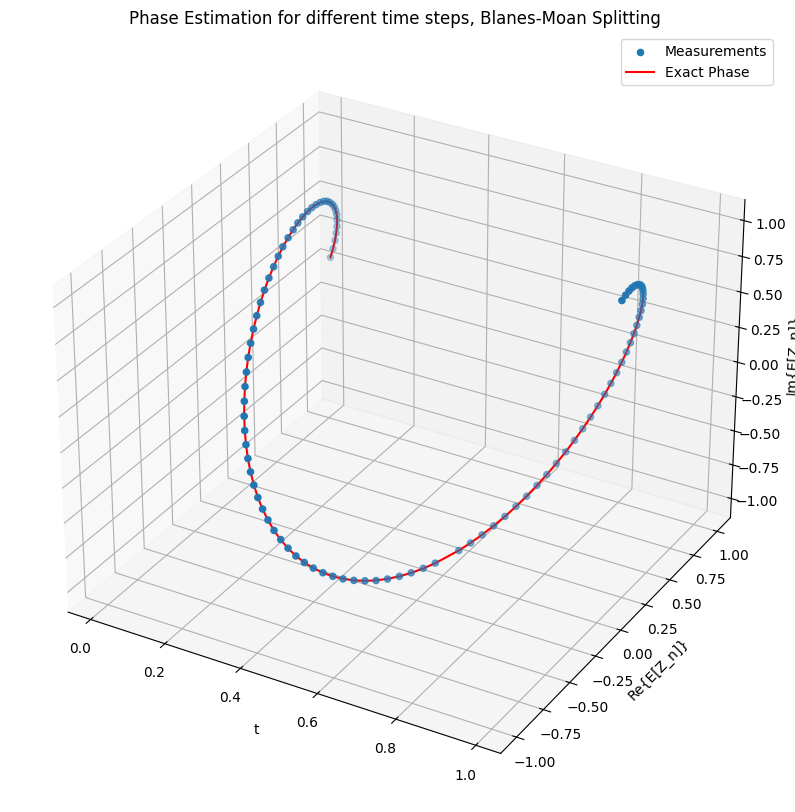

In [13]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

phase_estimates = np.array(phase_estimates)
phase_exacts = np.array(phase_exacts)
ax.scatter(phase_estimates[:, 0], phase_estimates[:, 1].real, phase_estimates[:, 1].imag, label="Measurements")
ax.plot(phase_exacts[:,0], phase_exacts[:,1].real, phase_exacts[:,1].imag, label="Exact Phase", color="red")
plt.title("Phase Estimation for different time steps, Blanes-Moan Splitting")
plt.xlabel("t")
plt.ylabel("Re{E[Z_n]}")
ax.set_zlabel("Im{E[Z_n]}")
ax.legend()

In [38]:
# Fitting of the gathered dataset to an exponential function.

def f(theta, phase_estimates):
    total_sum = 0
    for i, t in enumerate(phase_estimates[:, 0]):
        Zn = phase_estimates[:, 1][i]
        total_sum += Zn * np.exp(1j*t*theta)
    return np.linalg.norm(total_sum)**2

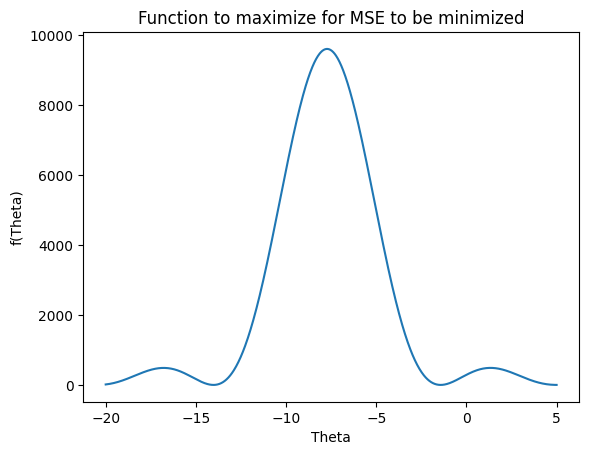

In [15]:
theta_values = np.linspace(-20, 5, 1000)
f_values = [f(theta, phase_estimates) for theta in theta_values]
plt.title("Function to maximize for MSE to be minimized")
plt.xlabel("Theta")
plt.ylabel("f(Theta)")
plt.plot(theta_values, f_values)
plt.show()

In [16]:
theta0 = scipy.optimize.fmin(lambda theta: -f(theta, phase_estimates), -7)
print("Absolute Error: ", np.linalg.norm(theta0 - eigenvalues_sort[0]))

Optimization terminated successfully.
         Current function value: -9603.106374
         Iterations: 14
         Function evaluations: 28
Absolute Error:  0.00134459859380609


In [ ]:
# Demonstrate dataset creation for QCELS Fitting with RQCOpt.
import qiskit
from qiskit import execute, transpile
import h5py
import rqcopt as oc
from utils_gsp import construct_ising_local_term

backend = qiskit.Aer.get_backend("aer_simulator")
tau, N, shots = (0.01, 100, 1e6)

phase_estimates = []
phase_exacts = []
for n in range(1, N):
    t = n*tau
    
    qc_cU_rqc = qiskit.QuantumCircuit(L+1)
    V_list = []
    path = f"../../src/rqcopt/results/ising1d_L{L}_t{t}_dynamics_opt_layers5.hdf5"
    try:
        with h5py.File(path, "r") as f:
            assert f.attrs["L"] == L
            assert f.attrs["J"] == J
            assert f.attrs["g"] == g
            V_list = list(f["Vlist"])
    except FileNotFoundError:
        strang = oc.SplittingMethod.suzuki(2, 1)
        _, coeffs_start_n5 = oc.merge_layers(2*strang.indices, 2*strang.coeffs)
        # divide by 2 since we are taking two steps
        coeffs_start_n5 = [0.5*c for c in coeffs_start_n5]
        print("coeffs_start_n5:", coeffs_start_n5)
        V_list = ising1d_dynamics_opt(5, t, False, coeffs_start_n5, path, niter=16)

    perms = [None if i % 2 == 0 else np.roll(range(L), -1) for i in range(len(V_list))]
    qcs_rqc = []
    for V in V_list:
        qc_rqc = qiskit.QuantumCircuit(2)
        qc_rqc.unitary(V, [0, 1])
        qcs_rqc.append(qc_rqc)
    for layer, qc_gate in enumerate(qcs_rqc):
        cgate = qc_gate.to_gate().control()
        for j in range(L//2):
            if perms[layer] is not None:
                qc_cU_rqc.append(cgate, [L, L-(perms[layer][2*j]+1), L-(perms[layer][2*j+1]+1)])
            else:
                qc_cU_rqc.append(cgate, [L, L-(2*j+1), L-(2*j+2)])
    
    qpe_real, qpe_imag = qc_QPE(L, end_state_qetu, qc_cU_rqc)
    
    try:
        counts_real = execute(transpile(qpe_real), backend, shots=shots).result().get_counts()
        phase_est_real = counts_real["0"]/shots - counts_real["1"]/shots
        counts_imag = execute(transpile(qpe_imag), backend, shots=shots).result().get_counts()
        phase_est_imag = counts_imag["0"]/shots - counts_imag["1"]/shots
        phase_est = phase_est_real + 1j*phase_est_imag
        phase_estimates.append((t, phase_est))
        exact_phase = np.exp(-1j*t*eigenvalues_sort[0])
        phase_exacts.append((t, exact_phase))
    except KeyError:
        continue

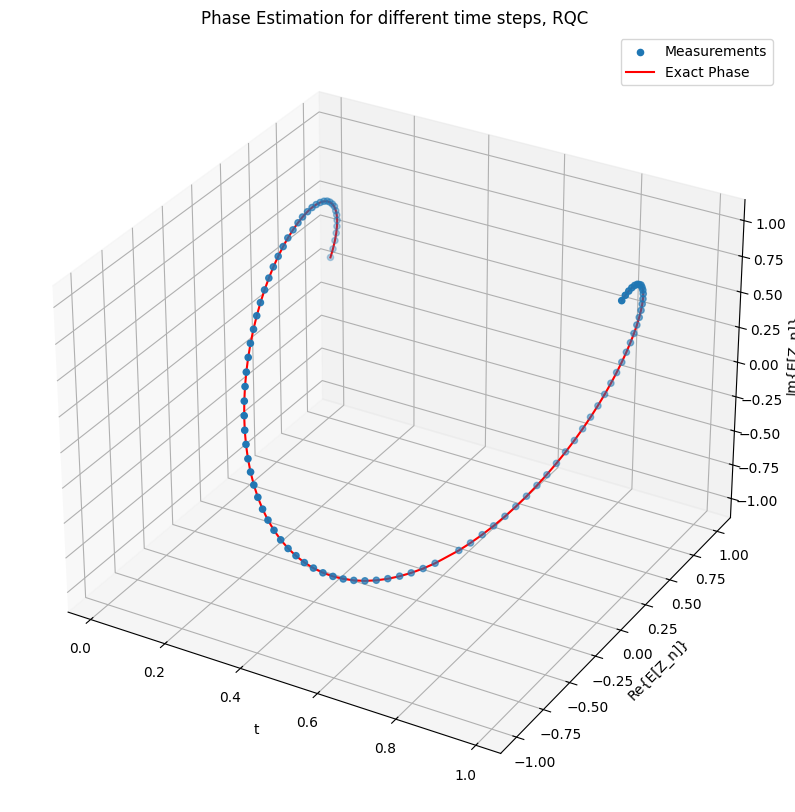

In [36]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

phase_estimates = np.array(phase_estimates)
phase_exacts = np.array(phase_exacts)
ax.scatter(phase_estimates[:, 0], phase_estimates[:, 1].real, phase_estimates[:, 1].imag, label="Measurements")
ax.plot(phase_exacts[:,0], phase_exacts[:,1].real, phase_exacts[:,1].imag, label="Exact Phase", color="red")
plt.title("Phase Estimation for different time steps, RQC")
plt.xlabel("t")
plt.ylabel("Re{E[Z_n]}")
ax.set_zlabel("Im{E[Z_n]}")
ax.legend()

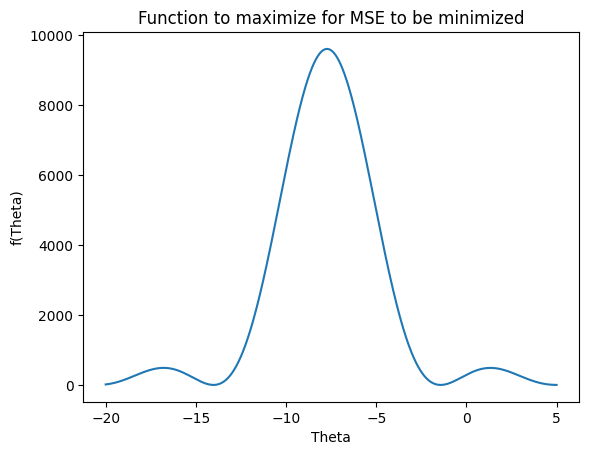

Optimization terminated successfully.
         Current function value: -9605.107538
         Iterations: 14
         Function evaluations: 28
Absolute Error:  0.0001934873436946205


In [39]:
theta_values = np.linspace(-20, 5, 1000)
f_values = [f(theta, phase_estimates) for theta in theta_values]
plt.title("Function to maximize for MSE to be minimized")
plt.xlabel("Theta")
plt.ylabel("f(Theta)")
plt.plot(theta_values, f_values)
plt.show()

theta0 = scipy.optimize.fmin(lambda theta: -f(theta, phase_estimates), -7)
print("Absolute Error: ", np.linalg.norm(theta0 - eigenvalues_sort[0]))